# Supermarket Sales

Description:
* 1000 rows, 5 parent and 5 child features

Parent features:
* Branch, City, Customer type, Gender, Product line, Unit price

Child features:
* Quantity, Tax 5%, Total, Date, Time, Payment

Source: https://www.kaggle.com/aungpyaeap/supermarket-sales

In [1]:
import sys
sys.path.append("C:/Users/notes/grab")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
sm = pd.read_csv("../data/supermarket.csv")

In [4]:
parent = sm[['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Unit price']]
parent.head()

,Branch,City,Customer type,Gender,Product line,Unit price
0,A,Yangon,Member,Female,Health and beauty,74.69
1,C,Naypyitaw,Normal,Female,Electronic accessories,15.28
2,A,Yangon,Normal,Male,Home and lifestyle,46.33
3,A,Yangon,Member,Male,Health and beauty,58.22
4,A,Yangon,Normal,Male,Sports and travel,86.31


In [5]:
child = sm[['Quantity', 'Tax 5%', 'Total', 'Date', 'Time', 'Payment']]
child.head()

,Quantity,Tax 5%,Total,Date,Time,Payment
0,7,26.1415,548.9715,1/5/2019,13:08,Ewallet
1,5,3.8200,80.2200,3/8/2019,10:29,Cash
2,7,16.2155,340.5255,3/3/2019,13:23,Credit card
3,8,23.2880,489.0480,1/27/2019,20:33,Ewallet
4,7,30.2085,634.3785,2/8/2019,10:37,Ewallet


In [6]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)
t_parent = enc.fit_transform(parent[['Branch', 'City', 'Customer type', 'Gender', 'Product line']])

X = np.append(t_parent, parent[['Unit price']], axis=1)

In [7]:
enc = OneHotEncoder(sparse=False)
t_child = enc.fit_transform(child[['Payment']])

child_month = pd.to_datetime(child['Date']).dt.month
child_day = pd.to_datetime(child['Date']).dt.day
child_hour = pd.to_datetime(child['Time']).dt.hour
child_dt = pd.concat([child_month, child_day, child_hour], axis=1).values

y = np.concatenate([child[['Quantity', 'Tax 5%', 'Total']], t_child, child_dt], axis=1)

In [8]:
import tensorflow as tf

X = X.astype(np.float32)
y = y.astype(np.float32)
dataset = tf.data.Dataset \
    .from_tensor_slices((X, y)) \
    .shuffle(X.size).batch(32)

In [9]:
from model.gmm import GMM

# Build GMM
gmm = GMM(x_features=X.shape[1],
          y_features=y.shape[1],
          n_components=100,
          n_hidden=50)
gmm.fit(dataset, epochs=1000, plot=True, verbose=True, logdir="gmm_supermarket")
y_hat = gmm.sample(X)

# %load_ext tensorboard
# %tensorboard --logdir experiments/logs/gmm_supermarket

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
0 [NLL: 1783.883544921875]
100 [NLL: 25.454639434814453]
200 [NLL: 22.681955337524414]
300 [NLL: 23.04935073852539]
400 [NLL: 20.993610382080078]
500 [NLL: 21.289546966552734]
600 [NLL: 23.081783294677734]
700 [NLL: 22.086284637451172]
800 [NLL: 21.12067985534668]
900 [NLL: 21.38677215576172]


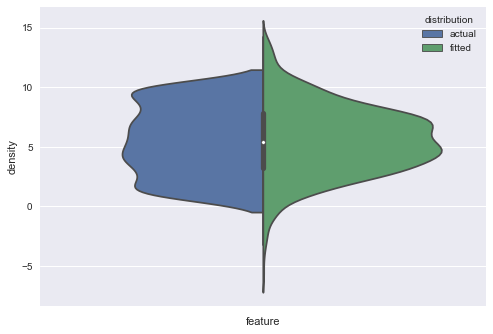

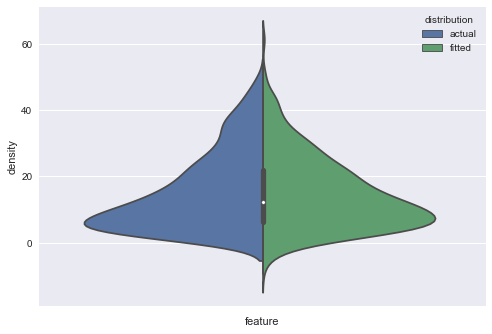

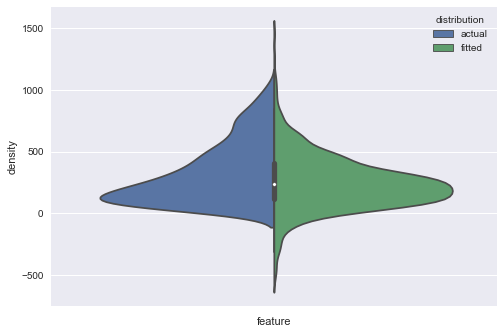

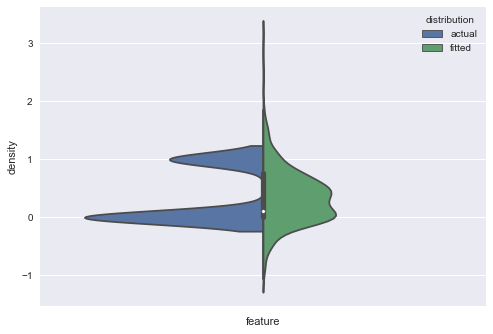

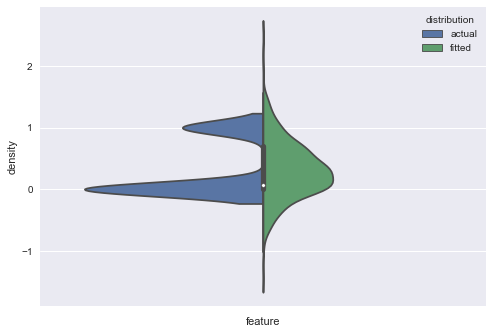

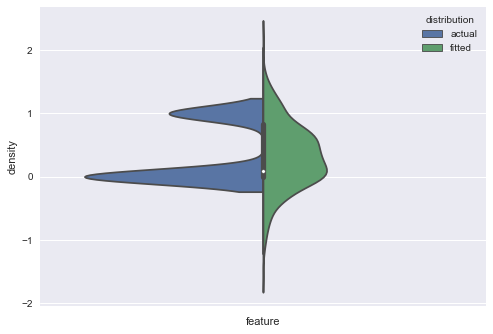

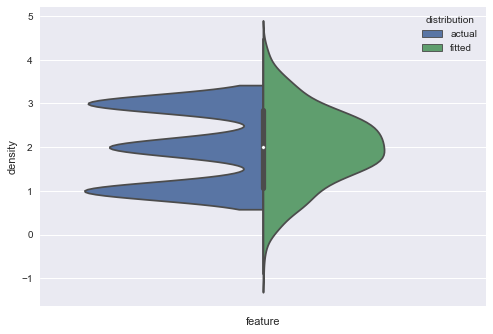

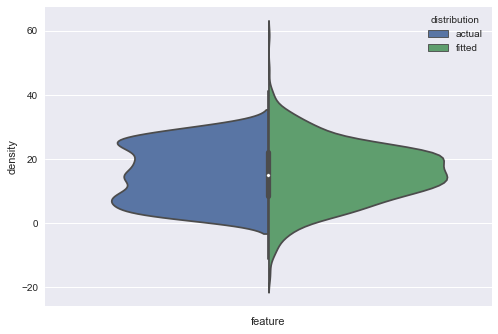

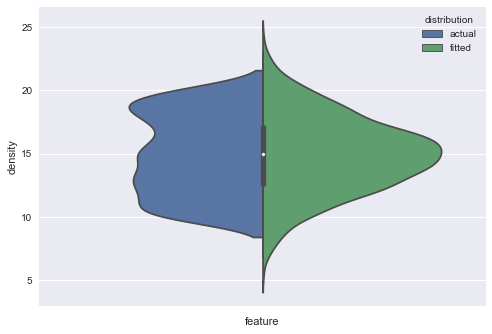

In [10]:
from visualisation.visualisation import Visualisation

gmm_viz = Visualisation(gmm, X, y)
for i in range(y.shape[1]):
    gmm_viz.plot_violin(y[:,i], y_hat[:,i])

In [11]:
from performance.performance import prob_overlap, kl, js

p, q = prob_overlap(y, y_hat, bins=4)
print("fKL:", kl(p, q))
print("rKL:", kl(q, p))
print("JS:", js(p, q))

fKL: 0.0013862943611198907
rKL: -0.0006931471805599453
JS: 8.494951839769862e-05


In [22]:
from model.cgan import CGAN

cgan = CGAN(x_features=X.shape[1],
            y_features=y.shape[1],
            latent_dim=32,
            g_hidden=32,
            d_hidden=32,
            label_smooth=0.9,
            d_dropout=0.1,
            gp_weight=10)

cgan.fit(dataset, epochs=1000, verbose=True, logdir="cgan_supermarket")

# %load_ext tensorboard
# %tensorboard --logdir logs/cgan_supermarket

0 [D loss: -101.21222686767578] [G loss: 4.049764633178711]
100 [D loss: -242.6365966796875] [G loss: 2583.56005859375]
200 [D loss: -988.08154296875] [G loss: 14137.140625]
300 [D loss: -3916.110595703125] [G loss: 34771.8125]
400 [D loss: -8684.5634765625] [G loss: 91658.1796875]
500 [D loss: -12218.234375] [G loss: 146545.71875]
600 [D loss: -17921.892578125] [G loss: 257592.1875]
700 [D loss: -35636.03515625] [G loss: 409465.40625]
800 [D loss: -57657.62890625] [G loss: 739338.875]
900 [D loss: -93119.1171875] [G loss: 808179.0]


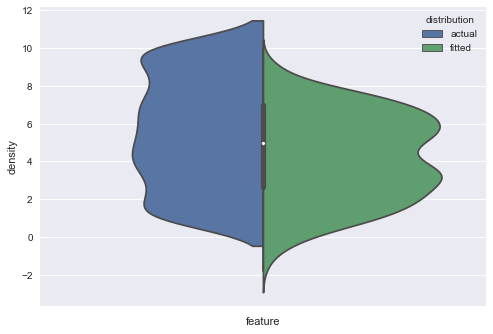

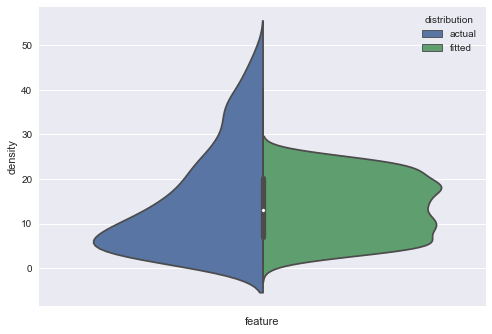

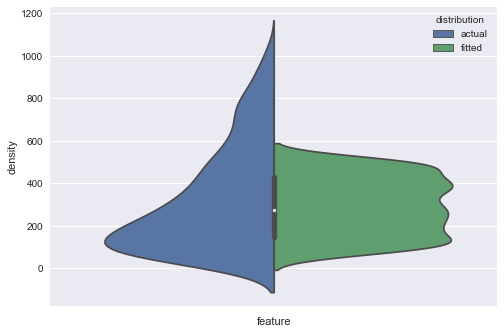

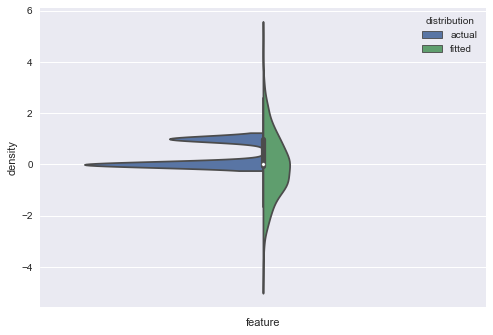

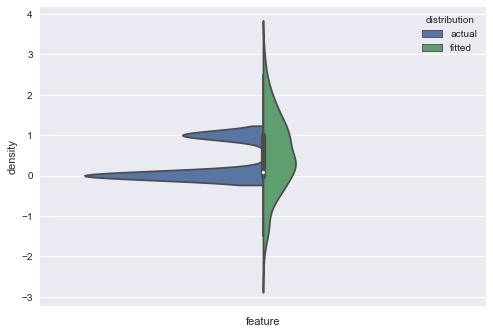

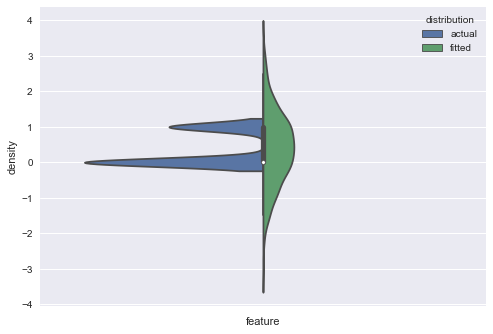

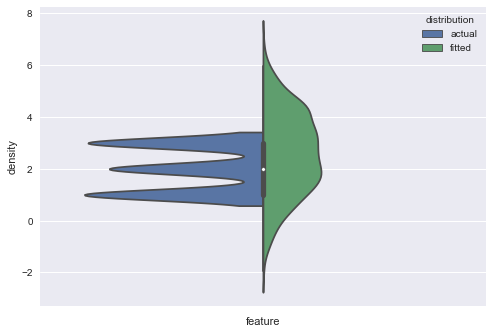

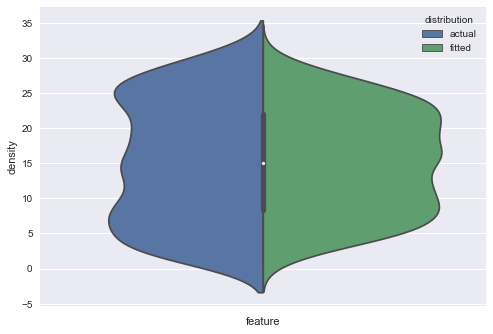

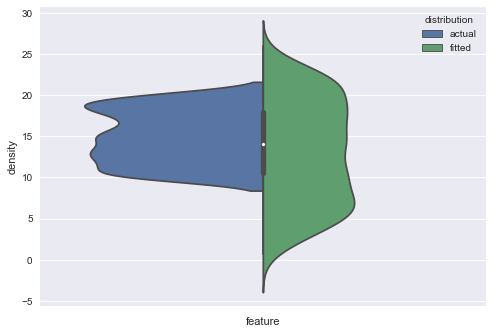

In [23]:
from visualisation.visualisation import Visualisation

y_hat = cgan.sample(X)
cgan_viz = Visualisation(cgan, X, y)
for i in range(y.shape[1]):
    cgan_viz.plot_violin(y[:,i], y_hat[:,i])

In [29]:
from performance.performance import prob_overlap, kl, js

p, q = prob_overlap(y, y_hat, bins=2)
print("fKL:", kl(p, q))
print("rKL:", kl(q, p))
print("JS:", js(p, q))

fKL: 0.5171204907606454
rKL: -0.02749744910807924
JS: 0.044851074014425674
